In [1]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
library(arrow, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)
library(ggplot2, warn.conflicts = FALSE)
library(tsibble, warn.conflicts = FALSE)
library(zeallot, warn.conflicts = FALSE)
library(sf, warn.conflicts = FALSE)
library(tidyr, warn.conflicts = FALSE)
library(factoextra, warn.conflicts = FALSE)

options(repr.plot.width = 9, repr.plot.res = 300)

source("notebooks/integrazioni_regionali/nb_tools/state_avail.R")
source("src/load/load.R")
source("src/analysis/data/clim_availability.R")
source("src/pairing/utils.R")
source("src/plot/plot_helpers.R")

first_date <- as.Date("2000-01-01")
last_date <- as.Date("2023-06-30")


Linking to GEOS 3.11.0, GDAL 3.5.3, PROJ 9.1.0; sf_use_s2() is TRUE

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa

terra 1.7.55

Caricamento del pacchetto richiesto: abind



In [2]:
m.scia <- open.dataset("SCIA", "metadata") |> filter(state == "Friuli-Venezia Giulia")
s.scia <- open.dataset("SCIA", "data") |>
    semi_join(m.scia, by = c("variable", "identifier")) |>
    collect()
m.dpc <- open.dataset("DPC", "metadata") |> filter(flavor == "qc_era5", state == "Friuli-Venezia Giulia")
s.dpc <- open.dataset("DPC", "data") |>
    filter(flavor == "qc_era5") |>
    semi_join(m.dpc, by = c("variable", "identifier")) |>
    arrange(variable, dpc, identifier, date) |>
    collect()


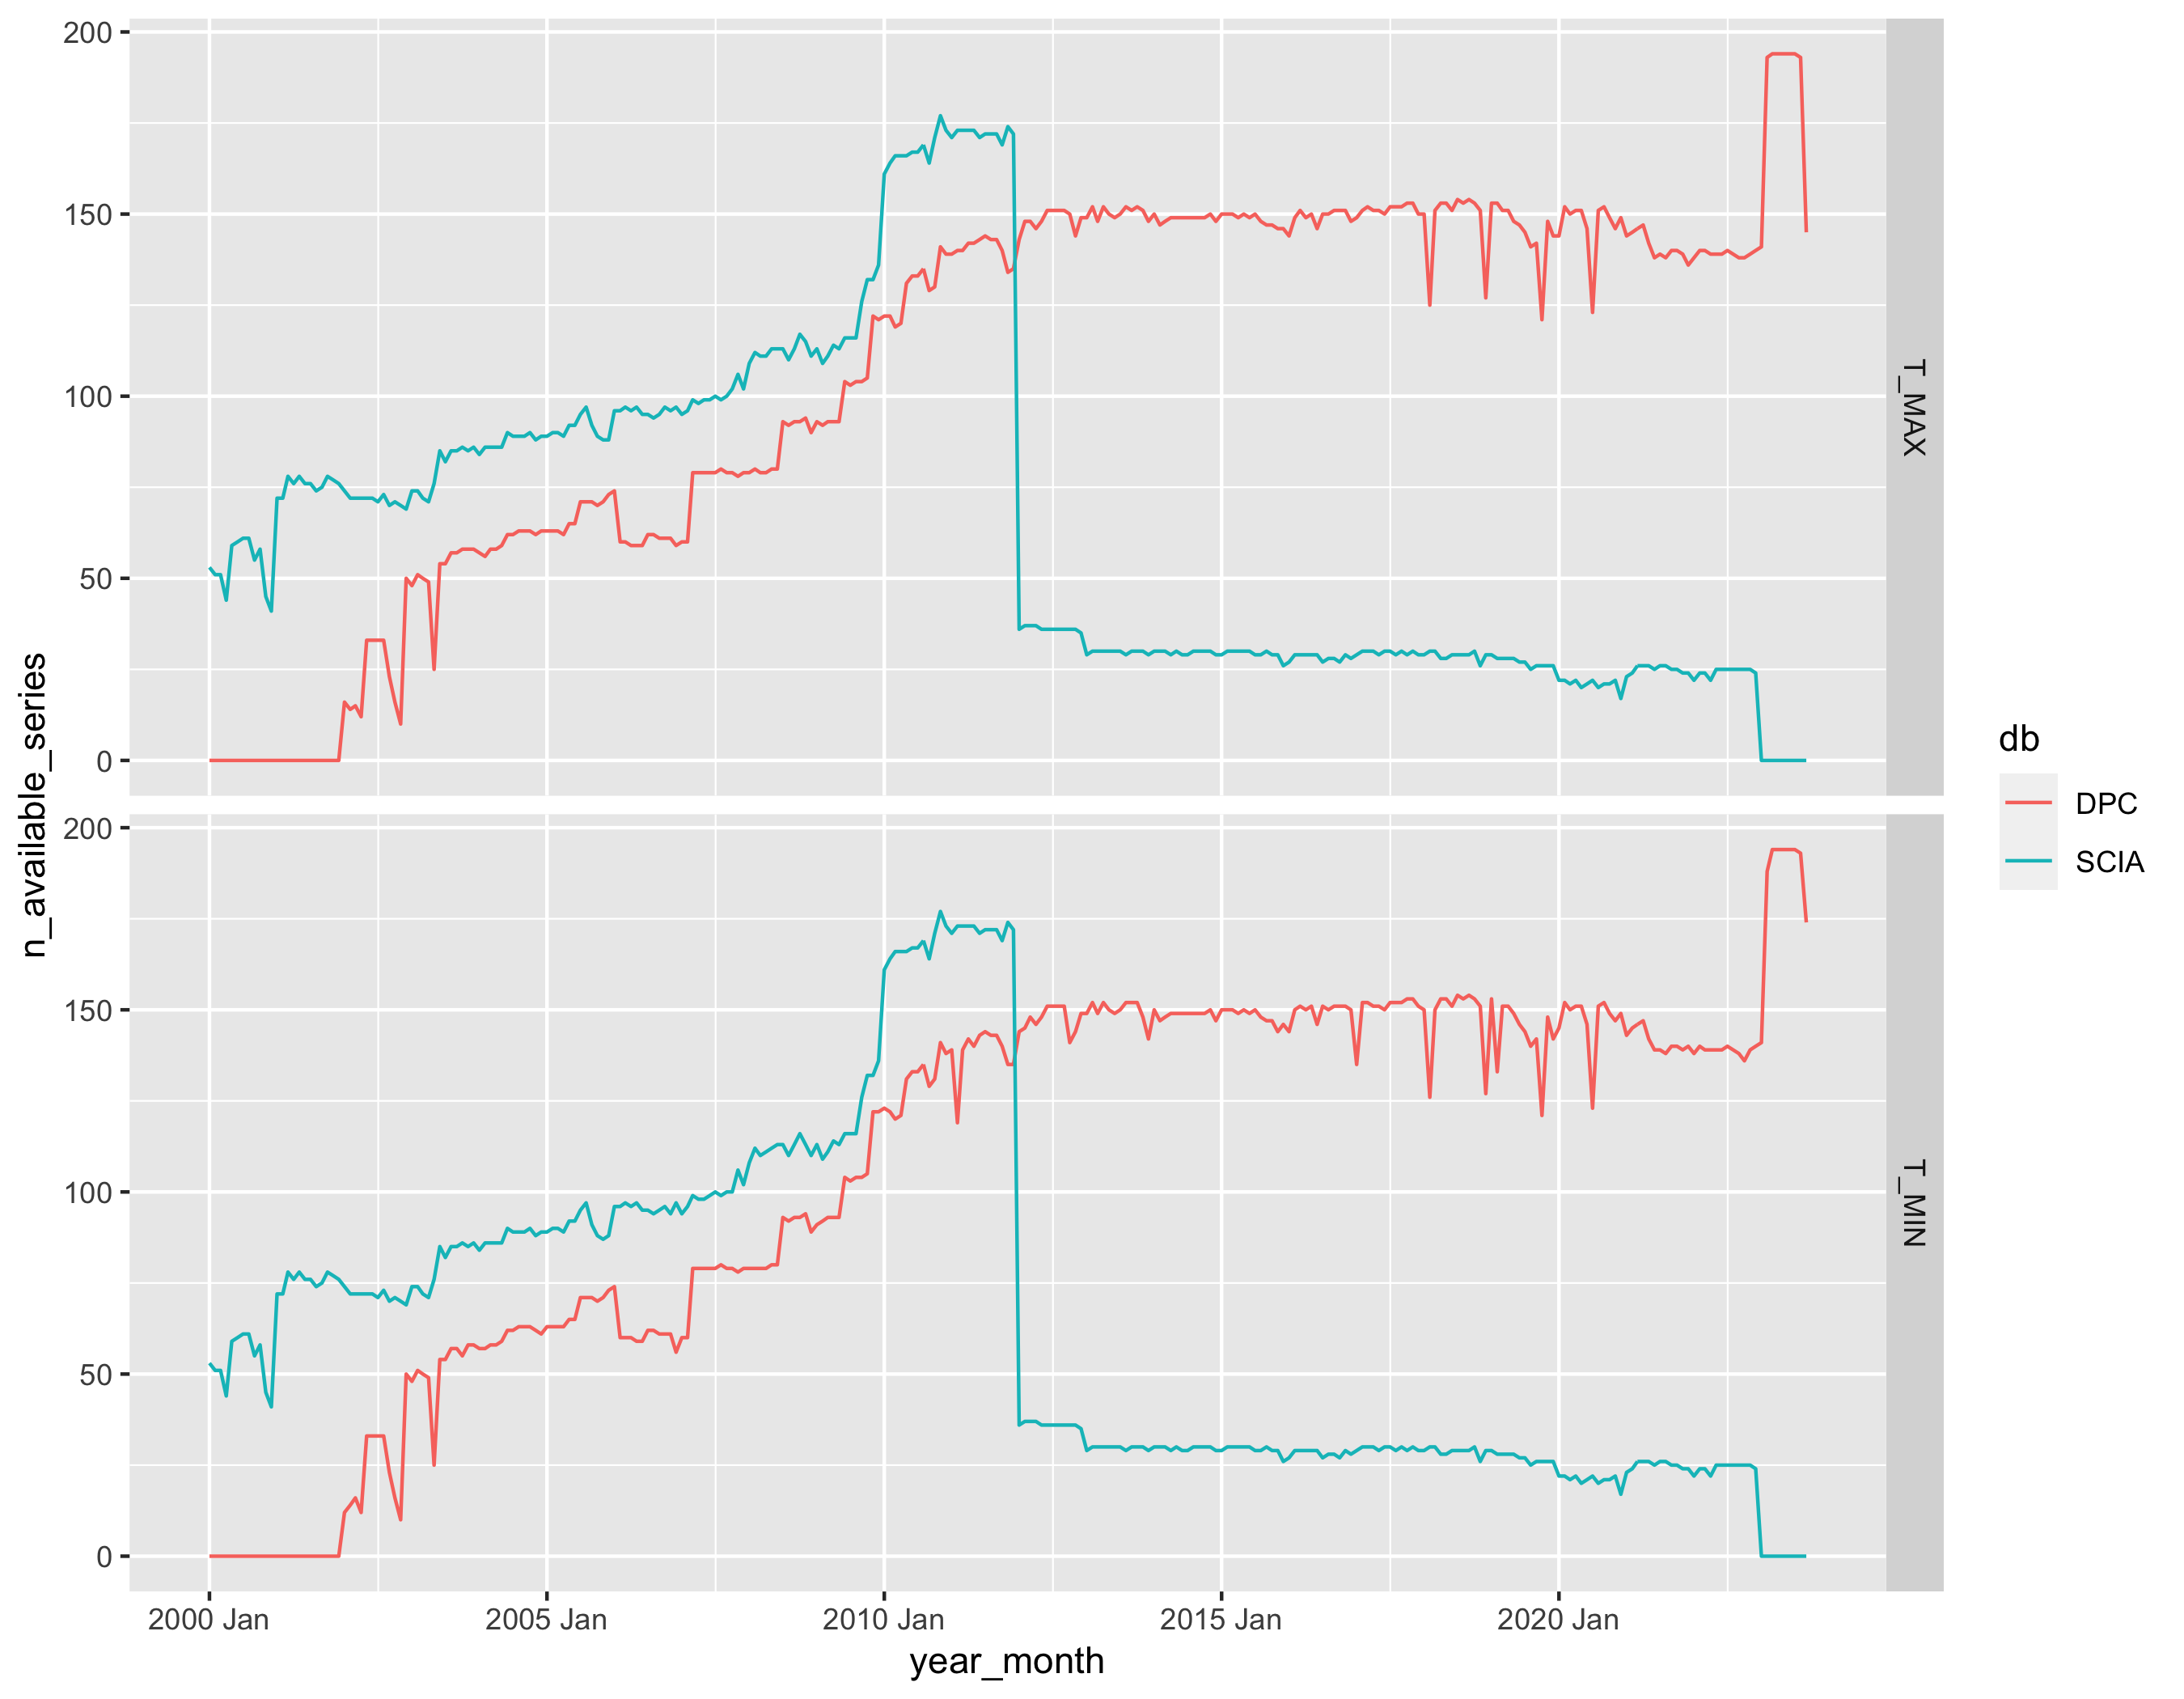

In [4]:
plot_state_avail(bind_rows(
    SCIA = s.scia |> mutate(identifier = as.character(identifier)),
    DPC = s.dpc,
    .id = "db"
))


In [3]:
friuli_buffer <- load.italian_boundaries("state") |>
    filter(shapeName == "Friuli Venezia Giulia") |>
    st_buffer(units::set_units(5, "km"))
dem <- read_stars("temp/dem/dem30.tif")


Reading layer `geoBoundaries-ITA-ADM1' from data source 
  `/Users/davidenicoli/Local_Workspace/Datasets/geoBoundaries/ITA-ADM1/geoBoundaries-ITA-ADM1.geojson' 
  using driver `GeoJSON'
Simple feature collection with 20 features and 5 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 6.626621 ymin: 35.49285 xmax: 18.52038 ymax: 47.09178
Geodetic CRS:  WGS 84


In [4]:
stations.scia <- open.dataset("SCIA", "metadata") |>
    collect() |>
    st_md_to_sf() |>
    st_filter(friuli_buffer, .predicate = st_within) |>
    prepare_metadata(dem)
stations.dpc <- open.dataset("BRUN", "metadata") |>
    filter(flavor == "qc_era5") |>
    collect() |>
    st_md_to_sf() |>
    st_filter(friuli_buffer, .predicate = st_within) |>
    prepare_metadata(dem)


In [5]:
matches_table <- st_join(
    stations.scia,
    stations.dpc,
    left = FALSE,
    suffix = c(".x", ".y"),
    join = st_is_within_distance,
    dist = units::set_units(5, "km")
) |>
    filter(variable.x == variable.y) |>
    group_by(identifier.x) |>
    mutate(matches.x = n()) |>
    ungroup() |>
    group_by(identifier.y) |>
    mutate(matches.y = n()) |>
    ungroup() |>
    add_distances(stations.scia |> filter(variable == "T_MIN"), stations.dpc |> filter(variable == "T_MIN"))


In [6]:
prepare_dss <- function(ds, identifier_var, cast_dtype) {
    data <- semi_join(ds |> filter(first_date <= date, date <= last_date),
        matches_table |>
            select(identifier = {{ identifier_var }}, variable) |>
            as_arrow_table() |>
            mutate(identifier = cast(identifier, cast_dtype)),
        by = join_by(variable, identifier)
    ) |>
        collect() |>
        arrange(variable) |>
        group_by(variable) |>
        group_map(
            ~ pivot_wider(.x, id_cols = date, names_from = identifier, values_from = value) |>
                arrange(date) |>
                as_tsibble(index = date) |>
                fill_gaps(.start = first_date, .end = last_date) |>
                as_tibble()
        )

    means <- purrr::map(
        data,
        ~ . |>
            group_by(month = month(date), year = year(date)) |>
            summarise(across(-date, ~ mean(., na.rm = TRUE)), .groups = "drop_last") |>
            summarise(across(-year, ~ mean(., na.rm = TRUE)), .groups = "drop")
    )

    list(data, means)
}

c(c(s.scia.tmax, s.scia.tmin), c(s.scia.tmax.means, s.scia.tmin.means)) %<-% (open.dataset("SCIA", "data") |>
    prepare_dss(identifier.x, uint32()))

c(c(s.dpc.tmax, s.dpc.tmin), c(s.dpc.tmax.means, s.dpc.tmin.means)) %<-% (open.dataset("BRUN", "data") |>
    filter(flavor == "qc_era5") |>
    select(-flavor) |>
    prepare_dss(identifier.y, utf8()))



In [7]:
analysis.tmin <- analyze_matches.wide(
    matches_table |> st_drop_geometry() |> filter(variable.x == "T_MIN"),
    s.scia.tmin,
    s.dpc.tmin,
    s.scia.tmin.means,
    s.dpc.tmin.means
)


In [9]:
analysis.tmax <- analyze_matches.wide(
    matches_table |> st_drop_geometry() |> filter(variable.x == "T_MAX"),
    s.scia.tmax,
    s.dpc.tmax,
    s.scia.tmax.means,
    s.dpc.tmax.means
)


In [10]:
analysis <- bind_rows(
    T_MIN = analysis.tmin,
    T_MAX = analysis.tmax,
    .id = "variable"
)


In [11]:
sensible_columns <- function(table, ...) {
    select(table, variable, identifier.x, starts_with("anagrafica"), version, distance, strSym, f0, fsemiside, starts_with("del"), ends_with("T"), ends_with("lap"), valid_days_both, ...)
}


In [ ]:
analysis |>
    group_by(variable, identifier.x) |>
    summarise(count = n())


In [25]:
sure_matches <- analysis |>
    filter(delT < 0.5) |>
    group_by(variable, identifier.x) |>
    slice_max(f0, na_rm = TRUE) |>
    ungroup() |>
    sensible_columns(identifier.y, -strSym, -sdT)


In [29]:
analysis.2 <- anti_join(analysis, sure_matches, by = c("variable", "identifier.x"))


In [34]:
analysis.2 |>
    filter(distance < 100) |>
    group_by(variable, identifier.x) |>
    slice_min(climatdelT) |>
    sensible_columns(identifier.y)


variable,identifier.x,anagrafica.x,anagrafica.y,version,distance,strSym,f0,fsemiside,delH,delZ,delT,sdT,corT,climatdelT,climatsdT,overlap,minilap,valid_days_both,identifier.y
<chr>,<int>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>
T_MIN,6074,Cervignano del Friuli,CERVIGNANO,1,97.992256924,0.8421053,NaN,NaN,0,0.0000000,NaN,NA,NA,1.0036042,0.6055021,0.4304358,0.00000000,0,TN_FVG_UD_CERVIGNANO_01_200251398
T_MIN,6077,Pordenone,PORDENONE_S_M,1,41.583628091,0.9393939,NaN,NaN,0,0.0000000,NaN,NA,NA,0.9717689,0.8403021,0.4725006,0.00000000,0,TN_FVG_PN_PORDENONE_S_M_01_200251403
T_MIN,6081,Monte Lussari,MONTE_LUSSARI,1,45.150191496,1.0000000,NaN,NaN,0,0.0000000,NaN,NA,NA,1.3192069,1.3848972,0.4369611,0.00000000,0,TN_FVG_UD_MONTE_LUSSARI_01_200251406
T_MIN,6088,Chievolis,CHIEVOLIS,1,46.348271746,1.0000000,NaN,NaN,5,0.0000000,NaN,NA,NA,0.8428632,0.3889350,0.4296201,0.00000000,0,TN_FVG_PN_CHIEVOLIS_01_200251422
T_MIN,6698,TARVISIO,NA,NA,0.001293135,NA,0.02357208,0.8268359,0,0.0000000,3.3022666,3.9534387,0.8379344,3.3023499,2.0106254,0.2017012,0.95497835,1103,TMND_160400
T_MIN,6732,TRIESTE,NA,NA,0.002877607,NA,0.01814882,0.8257713,12,0.0000000,3.3926044,3.2996684,0.9257995,2.8775822,1.9694802,0.2633419,0.97825122,2204,TMND_161100
T_MIN,8095,Fossalta di Portogruaro,FOSSALTA_DI_PORTOGRUARO_CMT,1,75.105845733,0.9583333,NaN,NaN,4,0.4646754,NaN,NA,NA,1.3519131,0.6189548,0.3295269,0.00000000,0,TN_VEN_VE_FOSSALTA_DI_PORTOGRUARO_CMT_01_200251231
T_MIN,8294,VAL DEI SASS,VAL_DEI_SASS,2,30.358163912,1.0000000,0.24933687,0.5570292,29,0.0000000,0.8245358,1.2793882,0.9762085,0.8362650,0.6299471,0.5216733,0.93781095,754,TN_FVG_PN_VAL_DEI_SASS_02_000504900
T_MIN,8297,AVIANO,AVIANO,2,52.686963185,1.0000000,0.43809524,0.6444444,2,0.0000000,0.5778836,1.1648760,0.9858531,0.5064011,0.3998533,0.5117688,0.99056604,945,TN_FVG_PN_AVIANO_02_000502800


## Integrazioni
Seleziono coppie di serie che vengono dalla stessa stazione per integrare i dati mancanti a SCIA.
Criteri:
<!-- - distinzione tra match multipli e singoli; -->
- una casistica per overlap molto bassi e una per overlap molto alti;
    - overlap alti:
        - altissima correlazione (> 0.95?);
        - basso delT (< )

In [53]:
classifier <- function(analysis) {
    with(
        analysis,
        case_when(
            (minilap >= 0.5) ~ case_when(
                (corT > 0.95 & delT < 0.5) ~ TRUE,
                .default = FALSE
            ),
            (minilap < 0.05) ~ case_when(
                (strSym > 0.8 & distance < 500) ~ TRUE,
                .default = FALSE
            )
            (minilap < 0.5) ~ case_when(
                (strSym > 0.6 & distance < 1000 & delT < )
                (strSym > 0.7) ~ 
            )
        )
    )
}


ERROR: Error in parse(text = x, srcfile = src): <text>:14:58: ')' inatteso
13:             (minilap < 0.5) ~ case_when(
14:                 (strSym > 0.6 & distance < 1000 & delT < )
                                                             ^


In [20]:
analysis_facs <- select(analysis, distance, strSym, starts_with("del"), ends_with("T"), ends_with("lap"), delTint) |>
    st_drop_geometry() |>
    mutate(across(everything(), ~ as.vector(scale(.))))


In [21]:
km <- stats::kmeans(analysis_facs |> drop_na(), centers = 2L, nstart = 10)


In [22]:
analysis_clust <- analysis |>
    drop_na(colnames(analysis_facs)) |>
    add_column(class = km$cluster)


In [112]:
analysis_clust |>
    group_by(identifier.x) |>
    slice_min(delT, na_rm = TRUE) |>
    ungroup() |>
    sensible_columns(class, -strSym, -delZ, -identifier.x, -sdT)


anagrafica.x,anagrafica.y,version,distance,delH,delT,delTint,corT,climatdelT,overlap,minilap,matches.x,matches.y,class
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
TARVISIO,PASSO_PREDIL,2,3528.89964,-191,1.6133333,1.8000000,0.8604602,2.4633695,0.33488697,0.01298701,8,7,1
Cansiglio - Tramedere,CANDAGLIA,2,2614.00602,-258,1.4751965,1.4698690,0.9752742,1.5345314,0.15078070,0.25427493,8,3,1
Col Indes (Tambre),VAL_DEI_SASS,2,3971.00745,-653,2.7217114,2.7284300,0.9804822,2.0035107,0.18585411,0.29403202,12,5,2
CA ZUL,CA_ZUL_INVASO,2,29.52731,126,0.7026490,0.7019868,0.9611429,2.6669786,0.10452109,0.04515550,6,3,1
CA SELVA,CA_SELVA_INVASO,2,25.56261,327,0.6443708,0.6821192,0.9638729,1.5589445,0.11768818,0.04602255,10,5,1
PONTE RACLI,TRAMONTI_INVASO,2,77.91316,151,0.7509934,0.7019868,0.9591651,0.6872051,0.12514565,0.04606467,10,5,1
PREPLANS,TRAMONTI_INVASO,2,3065.59086,6,2.9080586,2.9065934,0.9357181,1.0076218,0.09951060,0.12733209,6,5,1
BORGO CILIA,TRAMONTI_INVASO,2,3806.00872,470,2.9634191,2.9834559,0.8919868,0.8759516,0.11023072,0.12977099,8,5,1
PORDENONE CAMPO ATLETICA,PORCIA,2,4925.07676,12,2.0339902,2.0320197,0.9861050,1.2083287,0.20939175,0.13542362,6,2,1


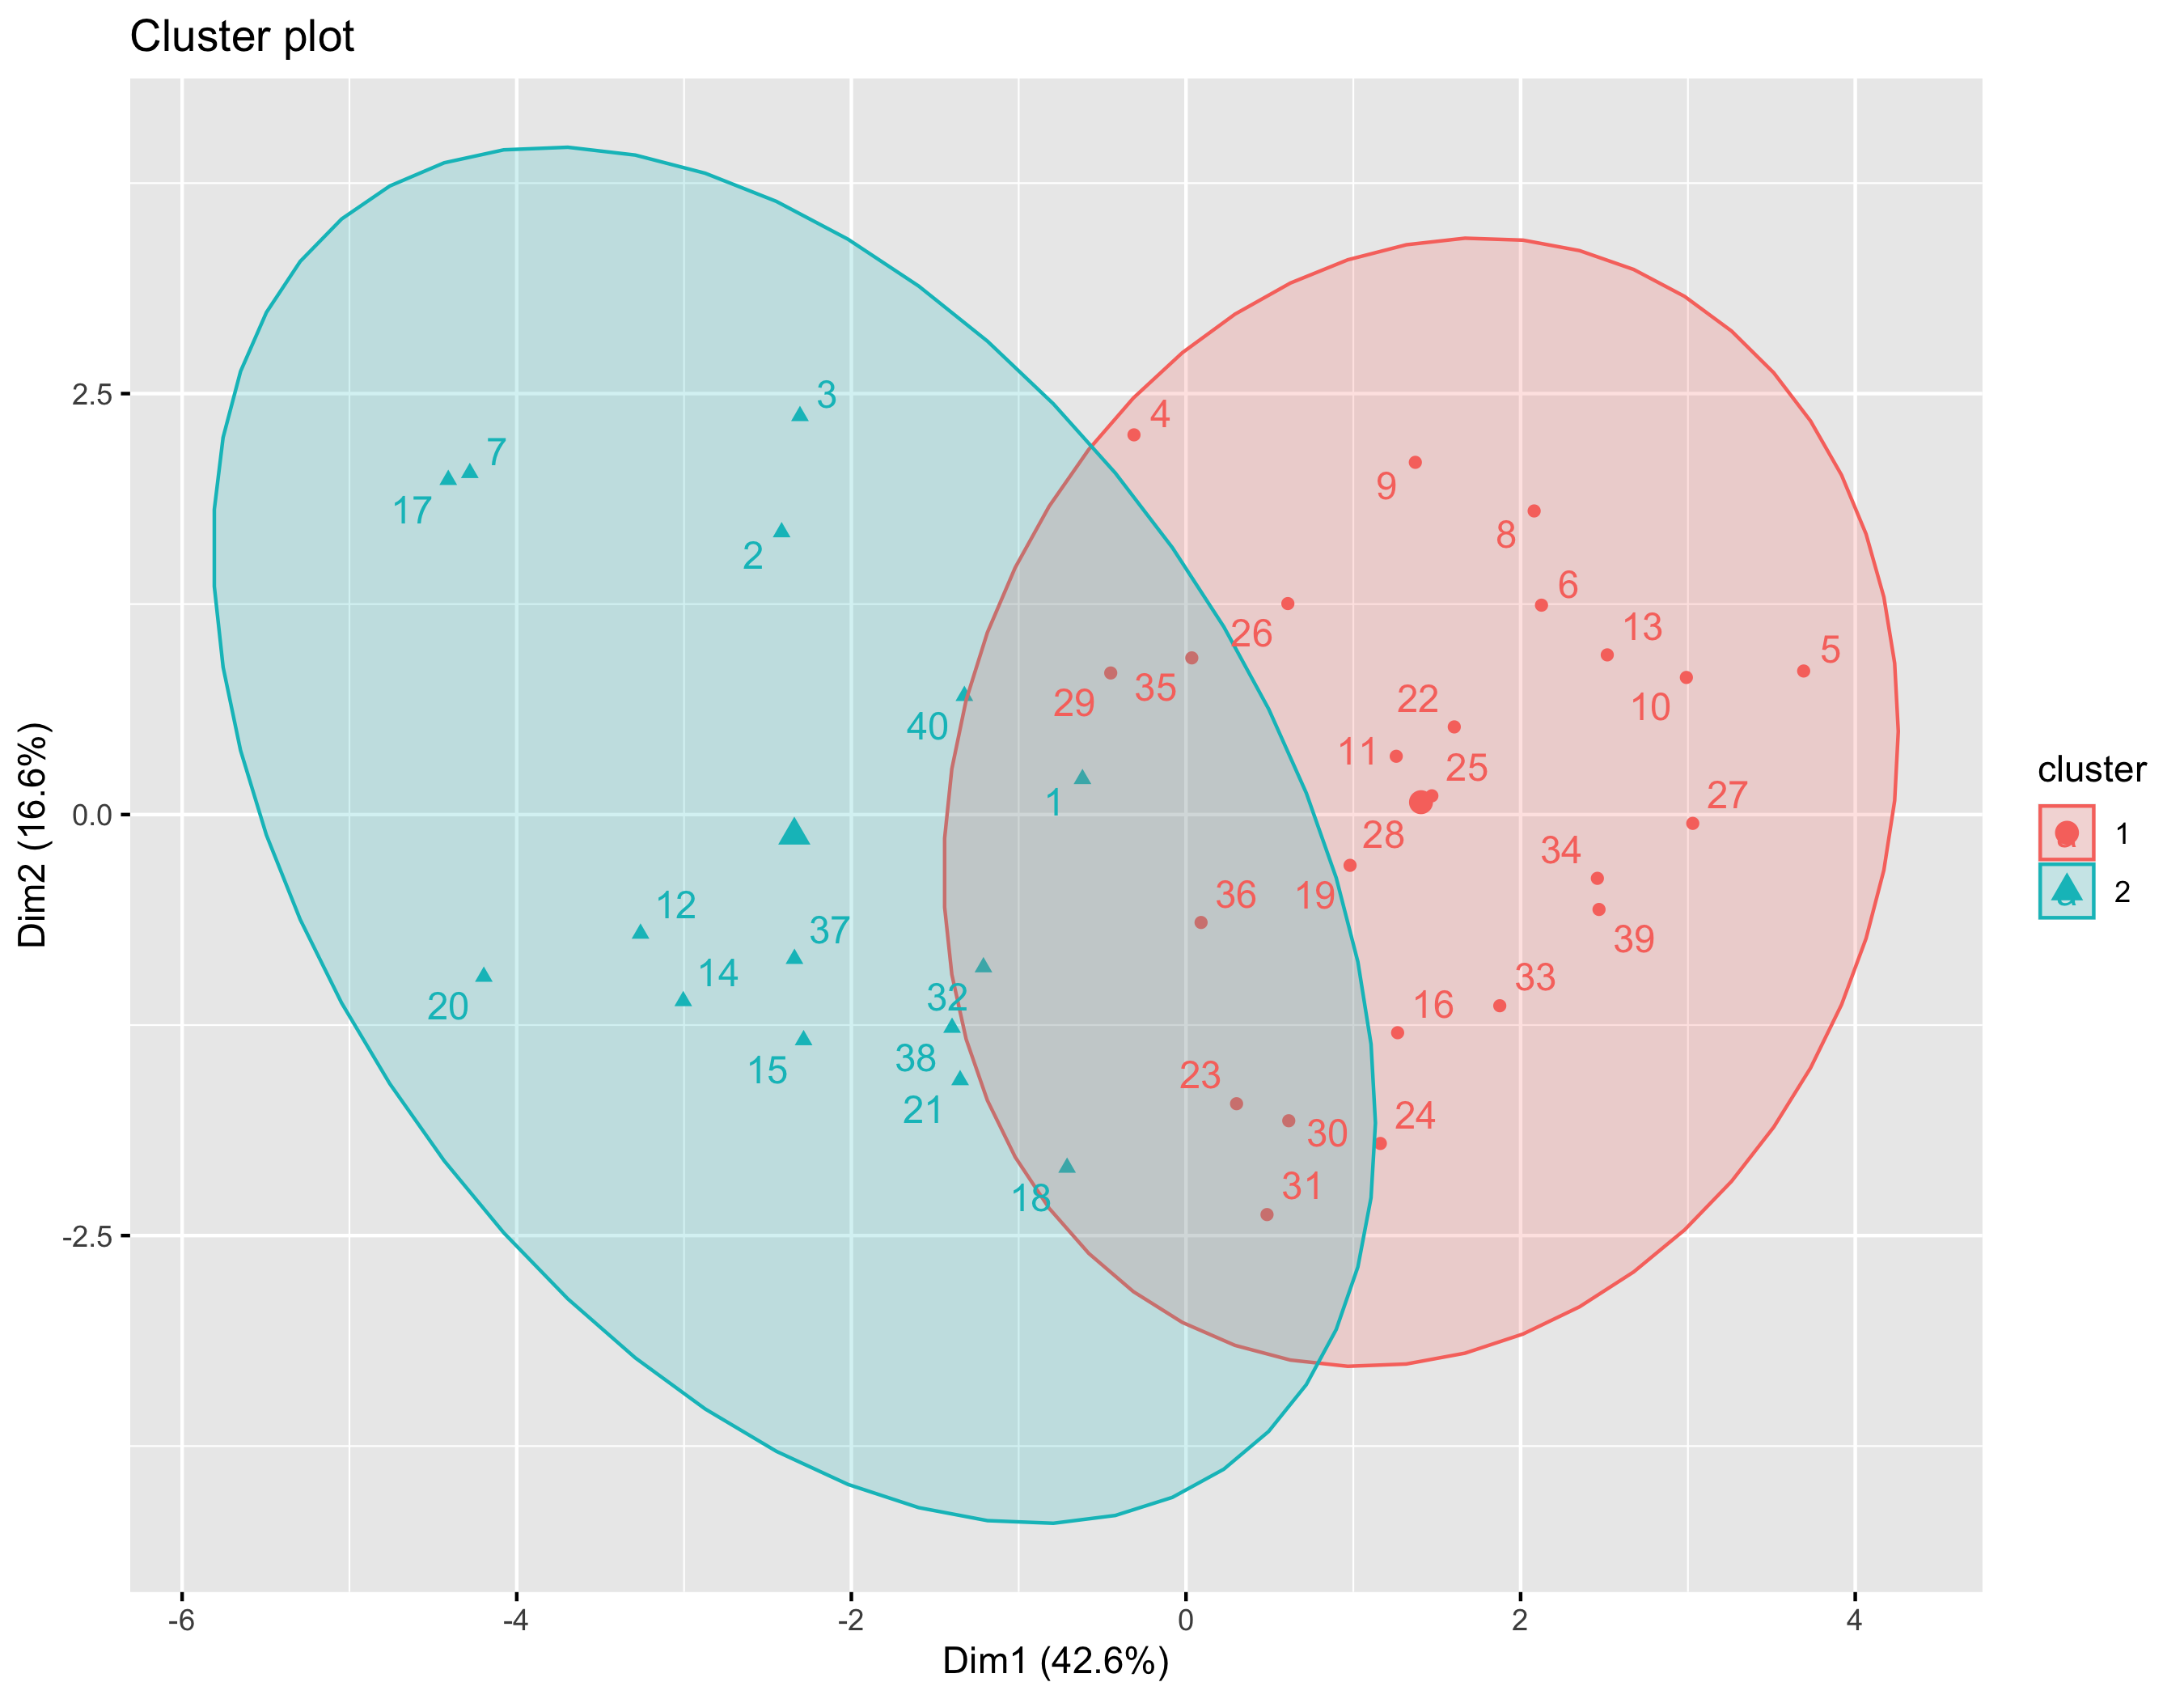

In [113]:
library(factoextra)
fviz_cluster(km, data = analysis_facs |> drop_na(), centroids = TRUE, repel = TRUE, ellipse.type = "norm")


In [45]:
ds <- dist(analysis_facs |> drop_na())
hc <- hclust(ds)
pam <- cluster::pam(ds, k = 2)


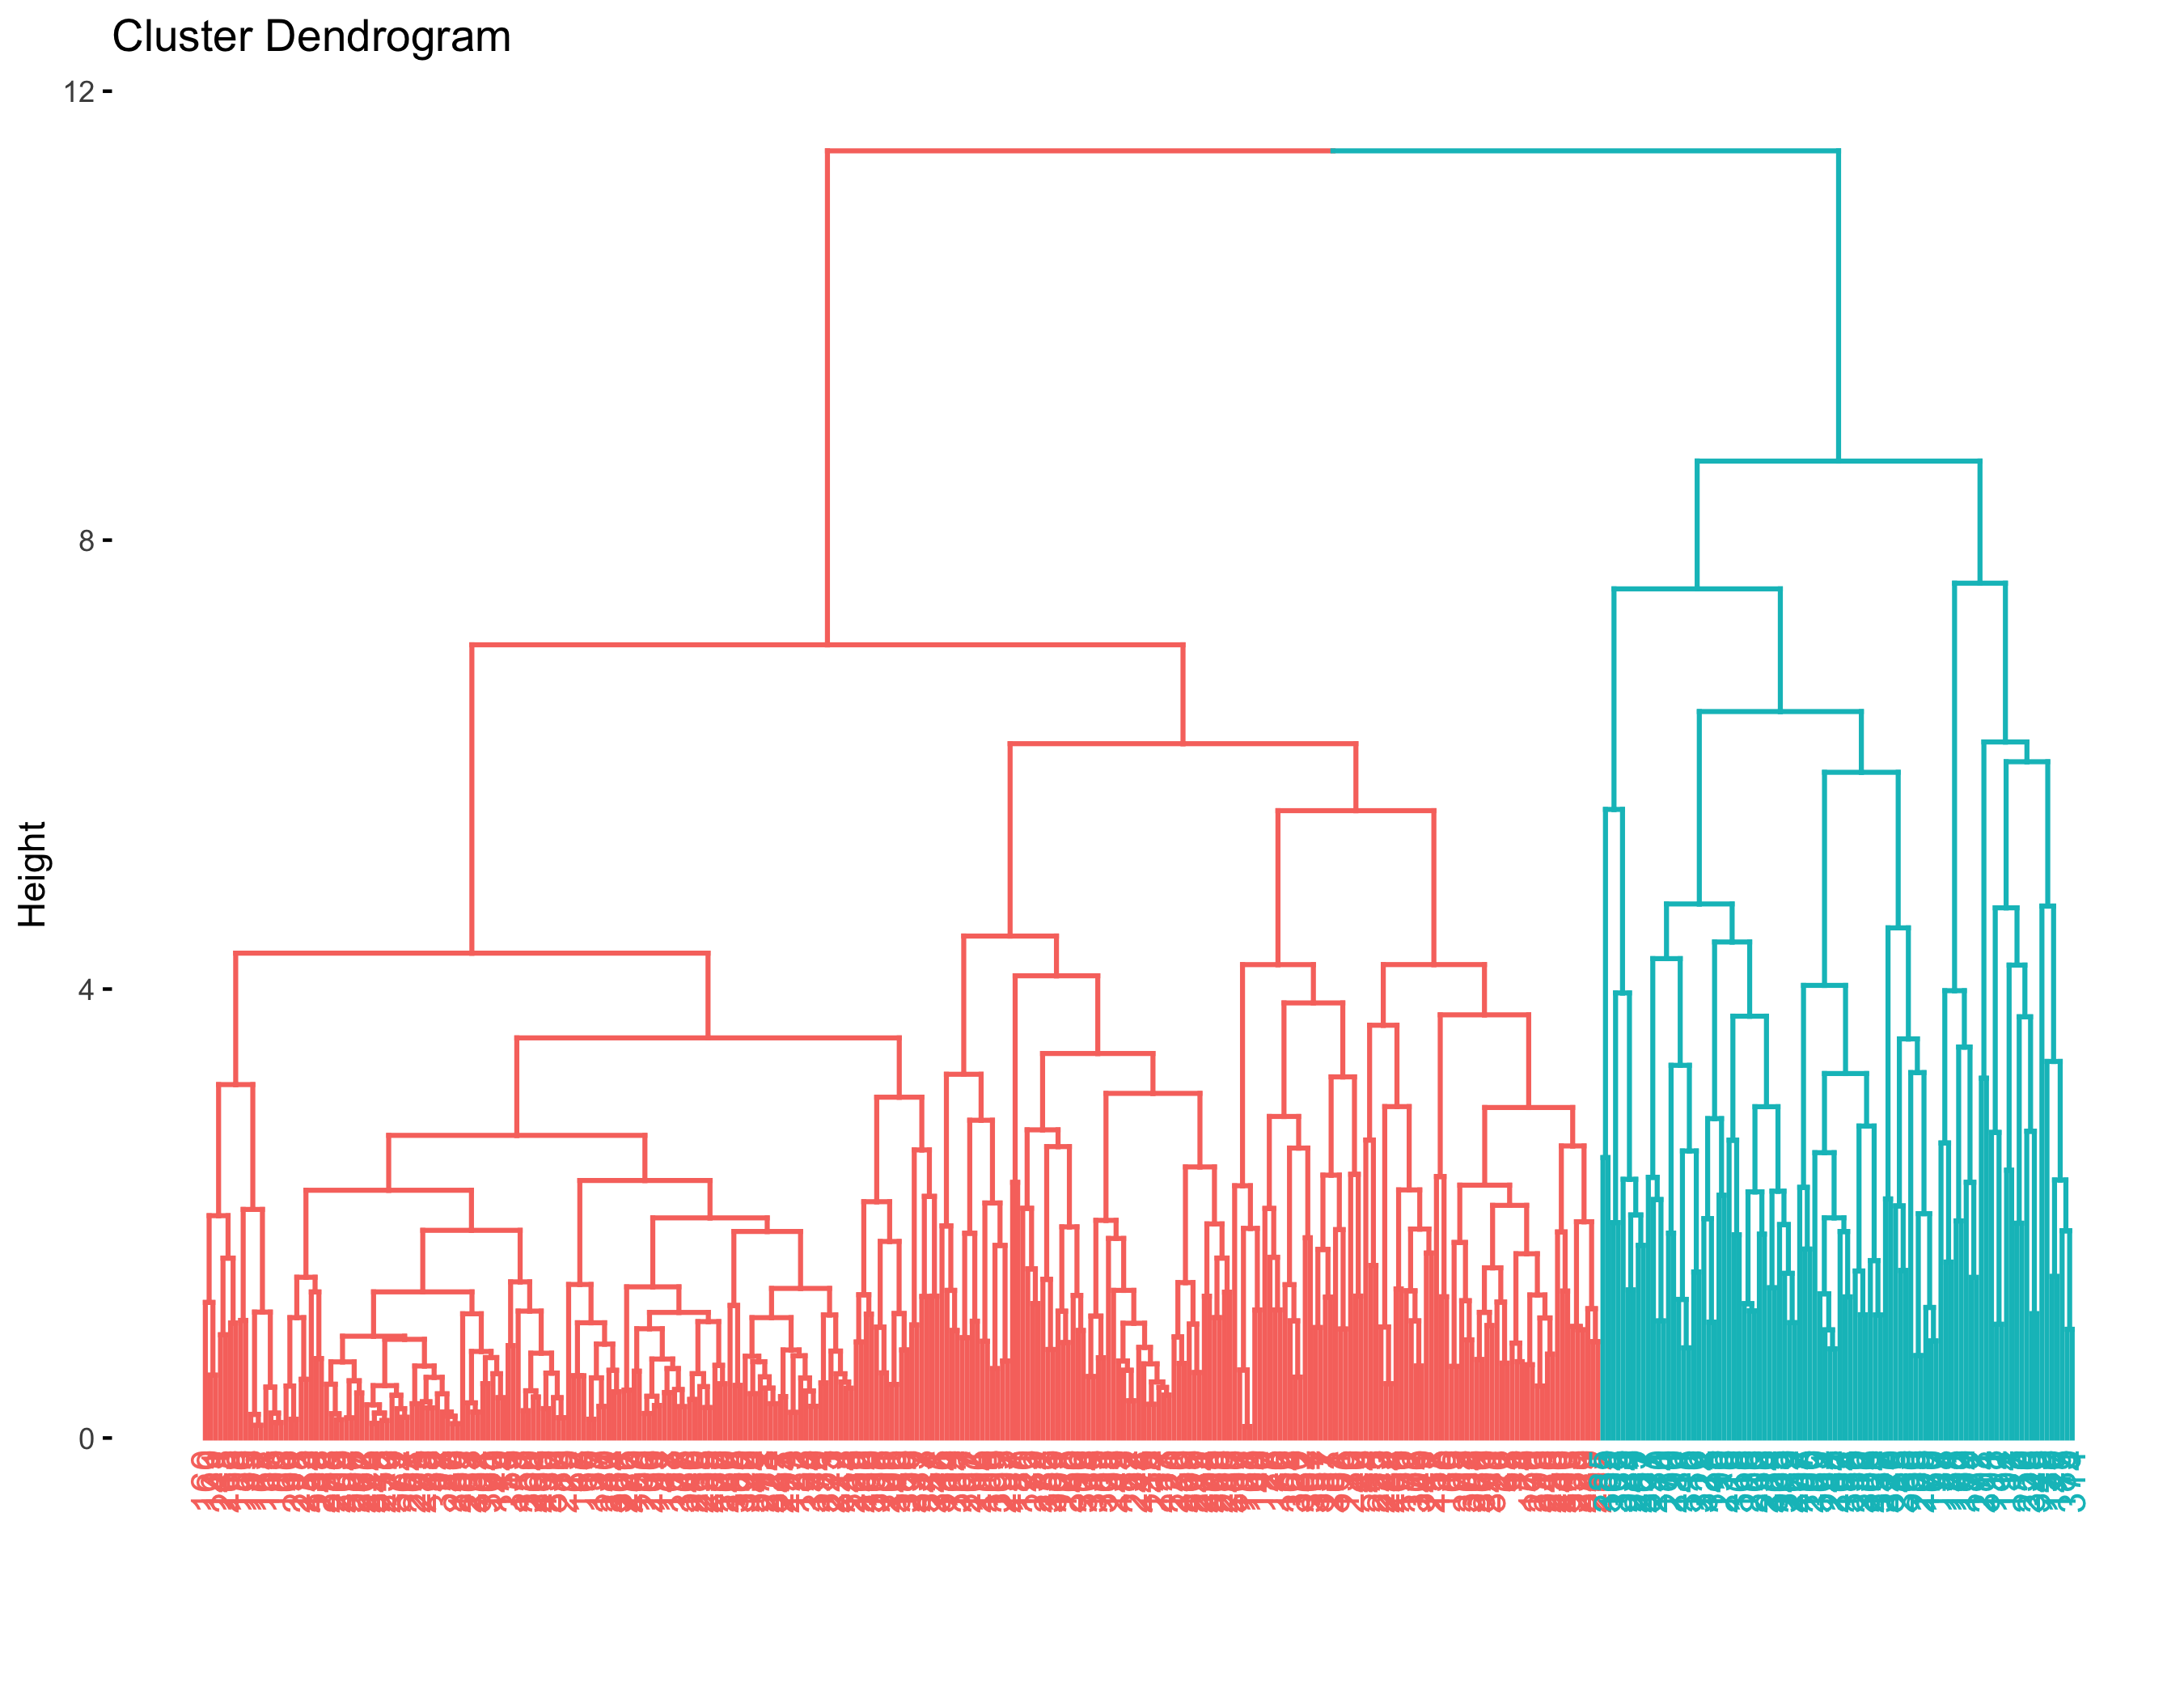

In [46]:
fviz_dend(hc, k = 2)


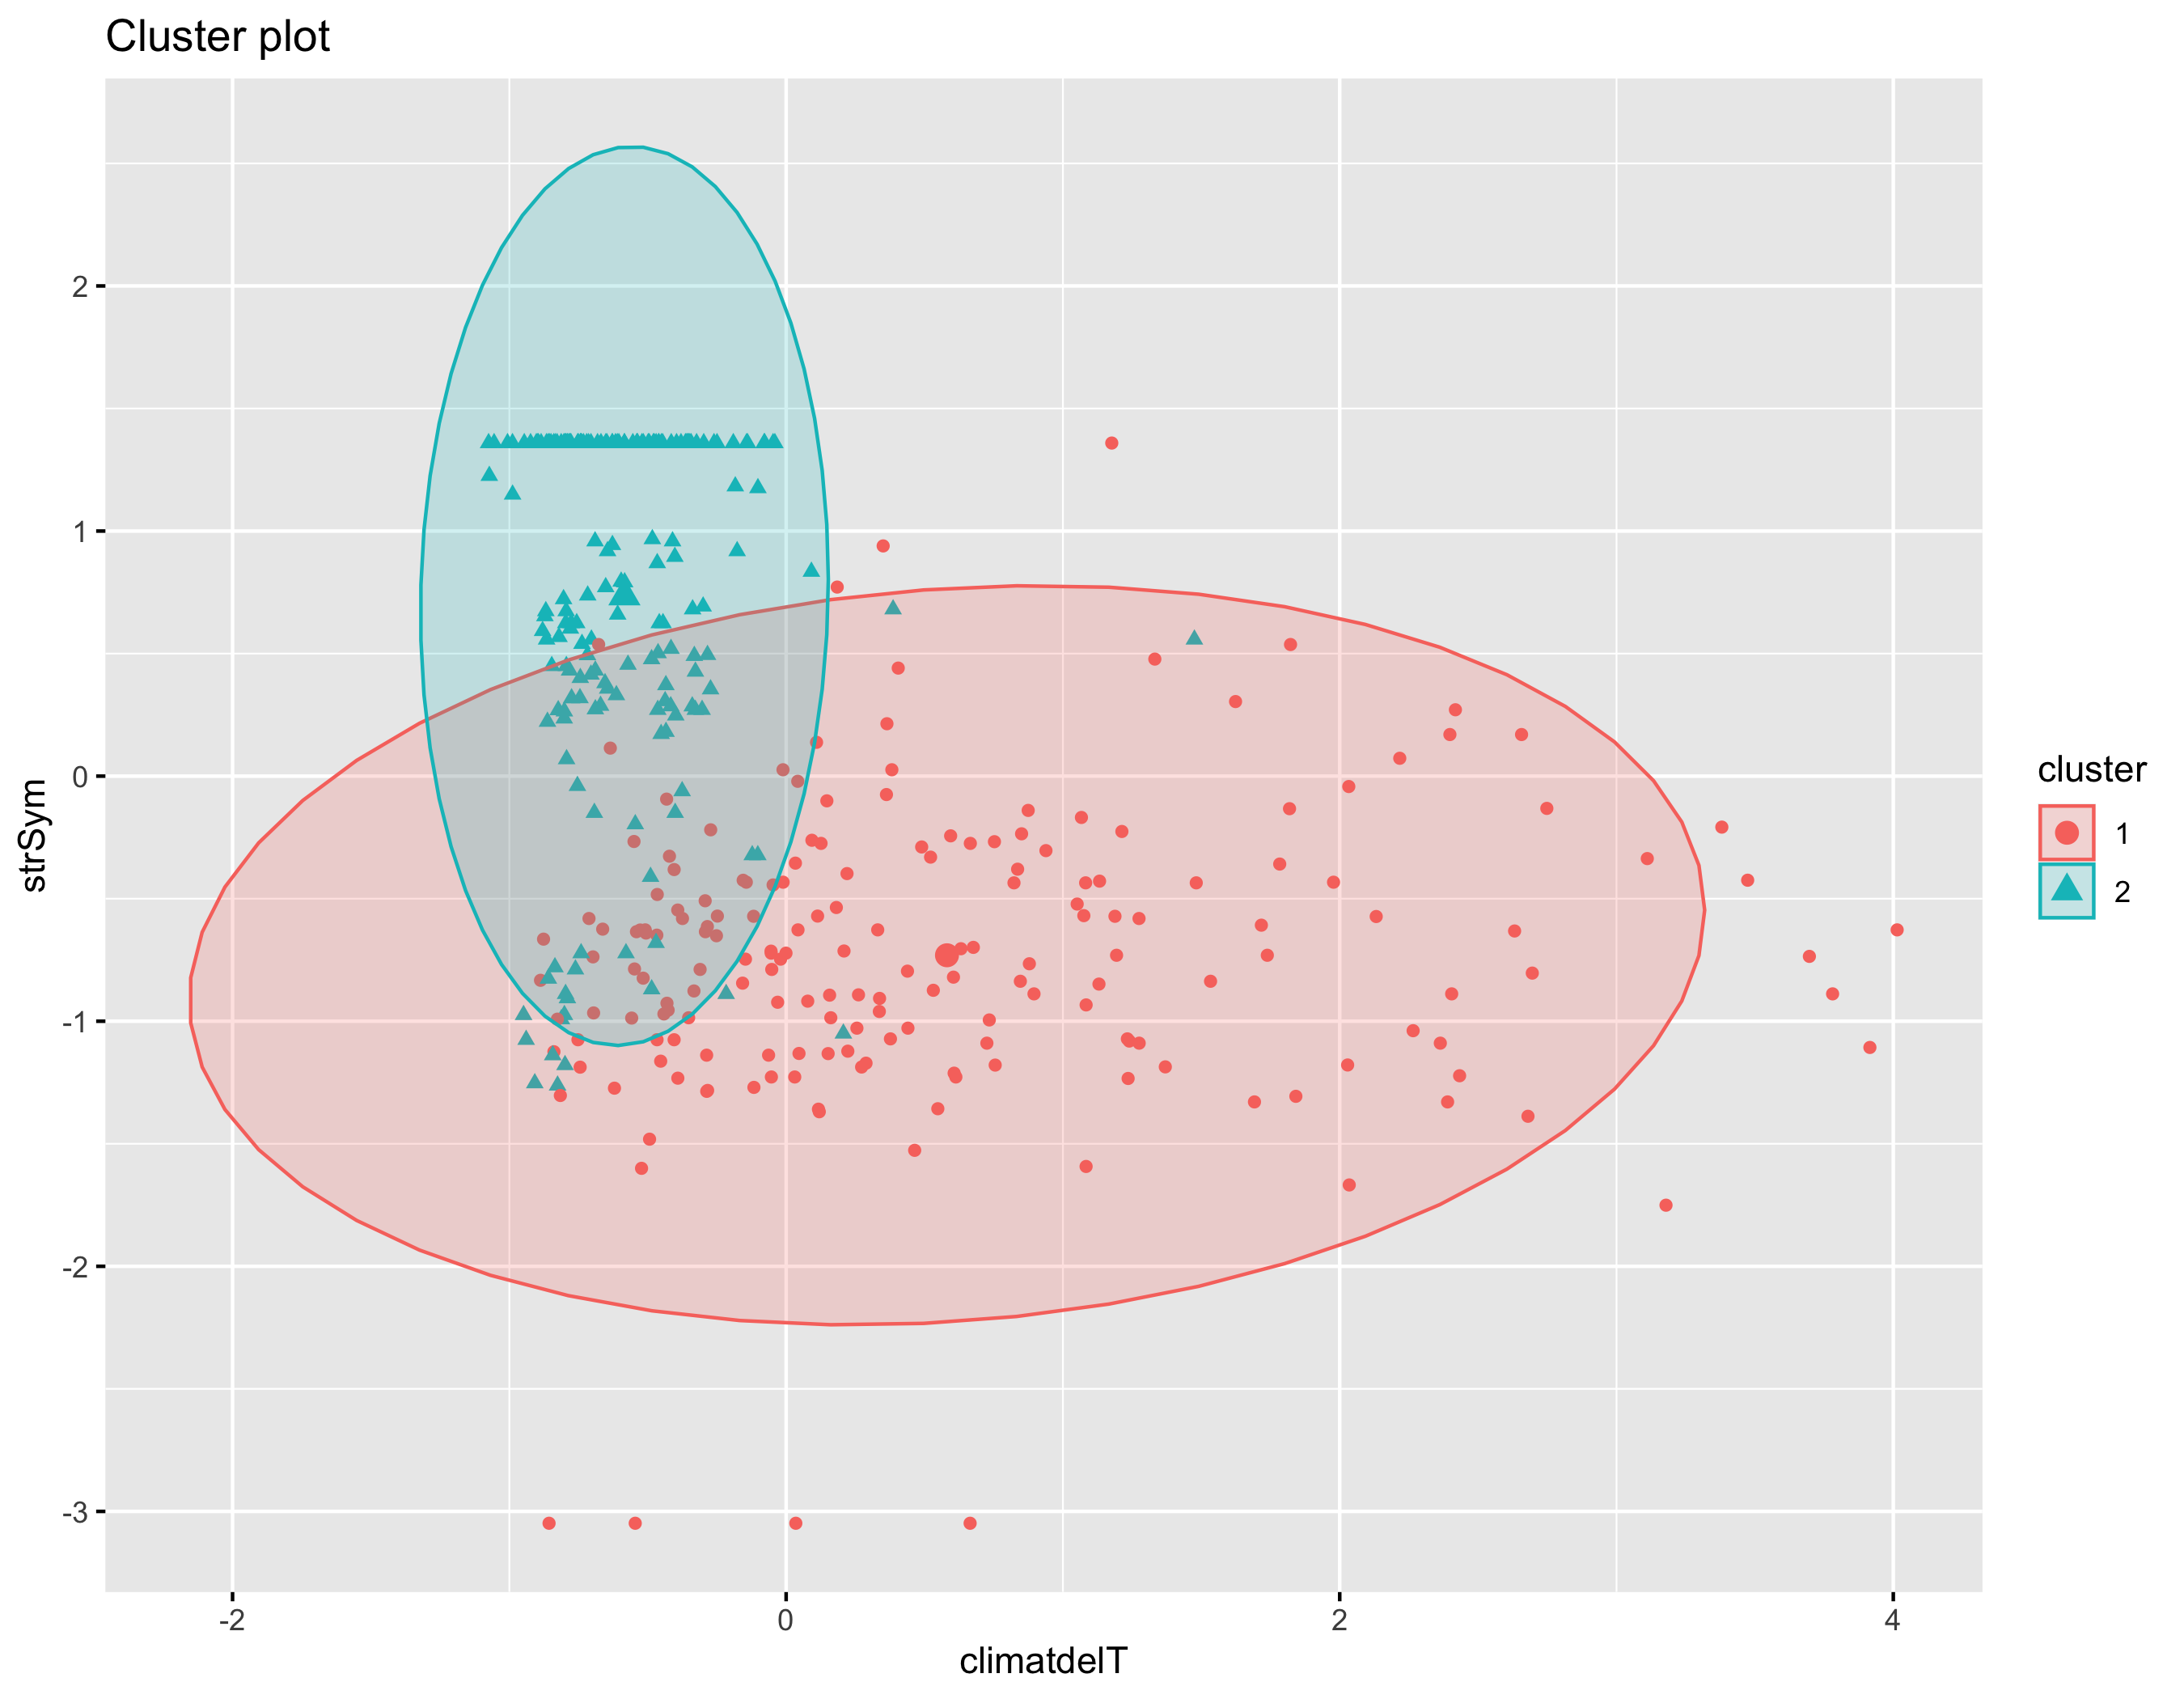

In [47]:
fviz_cluster(c(pam, list(data = analysis_facs |> drop_na())), geom = "point", ellipse.type = "norm", choose.vars = c("climatdelT", "strSym"))


In [121]:
hc_clusters <- cutree(hc, k = 2)
analysis_clust2 <- analysis |> add_column(class = factor(hc_clusters))


In [124]:
analysis_clust2 |> sensible_columns(class, -delZ, -sdT, -identifier.x, -delTint, -overlap)


anagrafica.x,anagrafica.y,version,distance,strSym,delH,delT,corT,climatdelT,minilap,matches.x,matches.y,class
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<fct>
ALBANA,PREPOTTO,2,4.176445e+02,0.0000000,-12,0.6255170,0.9848311,0.2937648,0.8213840,4,1,1
ALBANA,SPESSA_DI_CIVIDALE,1,3.986382e+03,0.4097222,6,NaN,NA,1.0902433,0.0000000,4,1,2
ALESSO,ALESSO,2,3.875644e+01,1.0000000,2,0.5854315,0.9868608,1.0201772,0.5659293,4,1,1
ALESSO,ALESSO,1,2.318490e+00,1.0000000,2,NaN,NA,1.9365804,0.0000000,4,1,1
AMPEZZO,ENEMONZO,1,4.908473e+03,0.5238095,92,NaN,NA,0.9636295,0.0000000,2,2,2
ANDRAZZA,FORNI_DI_SOPRA,2,1.281805e+01,0.4861111,7,0.5281333,0.9854491,0.3612111,0.8586984,4,3,1
ANDRAZZA,FORNI_DI_SOPRA,1,7.340160e+02,0.4861111,-72,NaN,NA,1.0647124,0.0000000,4,3,2
ANDREIS PIAZZOLA CAMPEGGIO,ANDREIS,2,1.019409e+03,0.7638889,-87,0.6503949,0.9851080,0.4073987,0.8583982,10,5,1
ANDREIS PIAZZOLA CAMPEGGIO,BARCIS,2,4.885375e+03,0.6111111,-118,1.6029548,0.9791970,1.1997535,0.8666834,10,4,1


In [51]:
stations.dpc |> filter(variable == "T_MIN", str_detect(anagrafica, "PREPOTTO"))


,region_,country,anagrafica,GSOD,user_code,MG,identifier,elevation,province,version,internal_id,state,dpc,flavor,variable,geometry
,<fct>,<fct>,<chr>,<lgl>,<chr>,<lgl>,<chr>,<dbl>,<fct>,<int>,<int>,<chr>,<lgl>,<chr>,<chr>,<POINT [arc_degree]>
1,dpc,IT,PREPOTTO,FALSE,NA,FALSE,TN_FVG_UD_PREPOTTO_02_000217500,117,UD,2,217500,Friuli-Venezia Giulia,TRUE,qc_era5,T_MIN,POINT (13.48842 46.04467)
2,dpc,IT,PREPOTTO_TS,FALSE,NA,FALSE,TN_FVG_TS_PREPOTTO_TS_01_200251440,0,TS,1,200251440,Friuli-Venezia Giulia,TRUE,qc_era5,T_MIN,POINT (13.69242 45.76027)


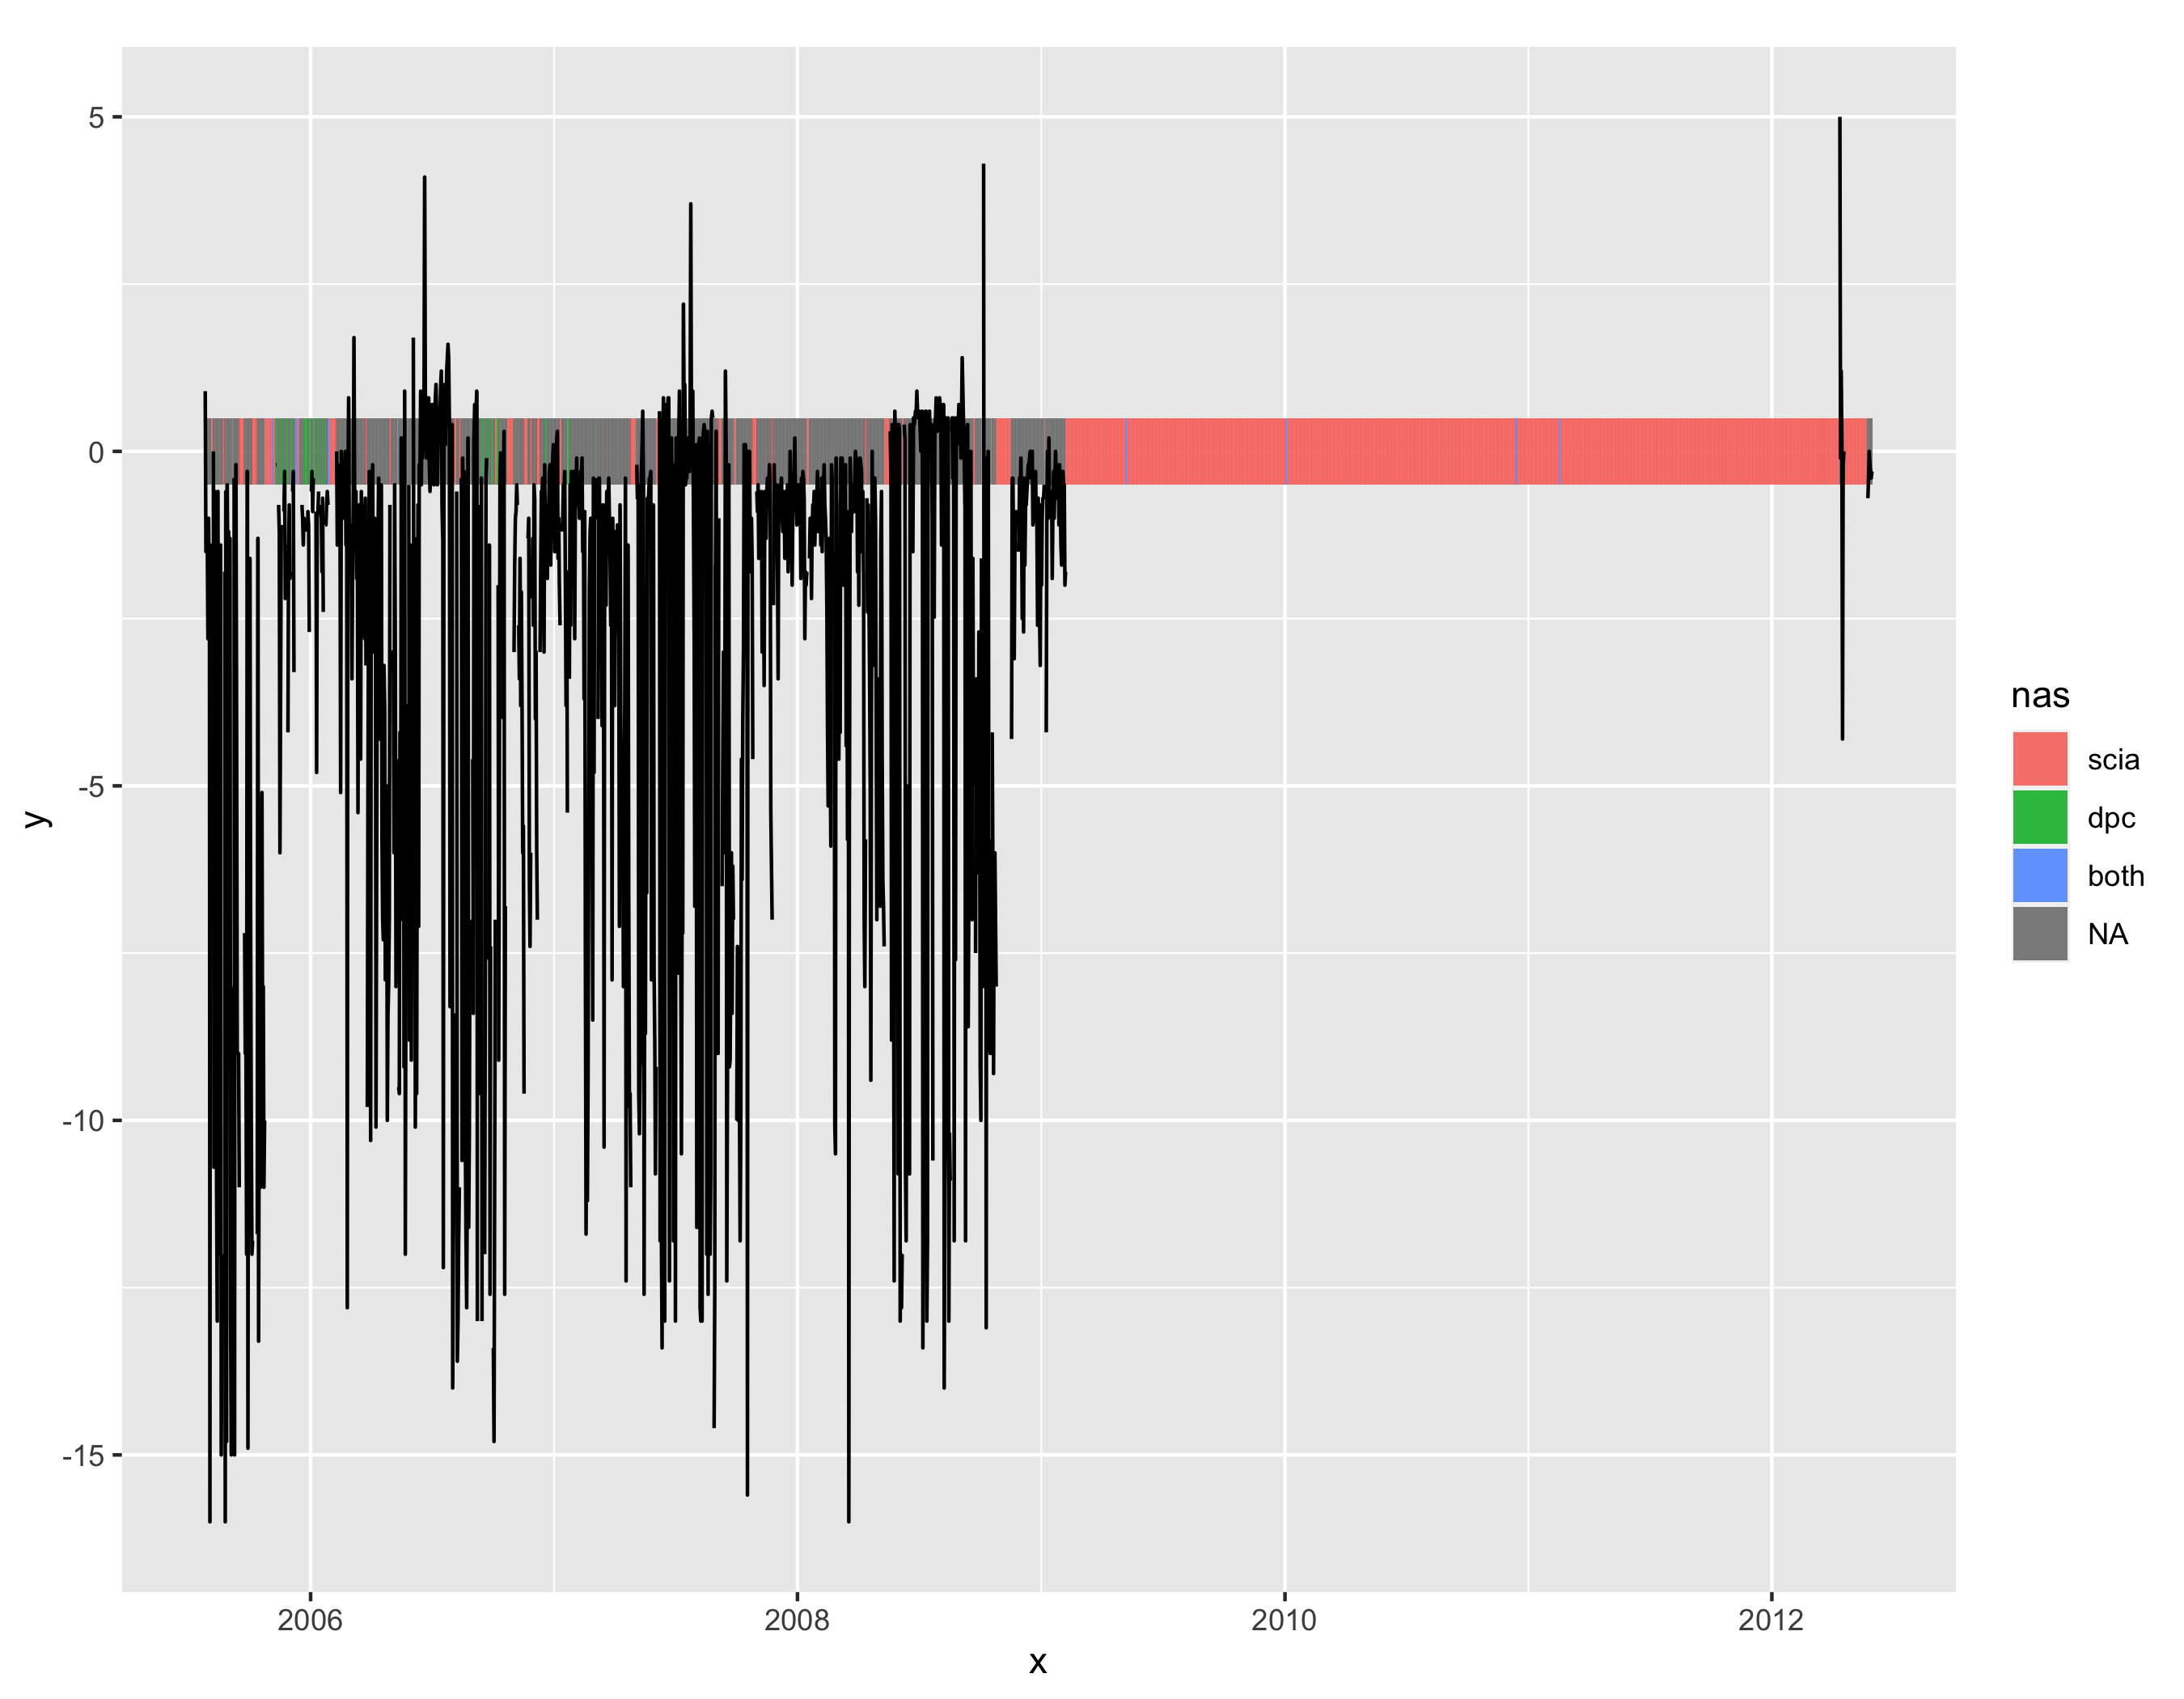

In [37]:
plot.sciavsdpc("T_MIN", 6698, "TMND_160400", "qc_era5", diffs = TRUE)
